
# 特征分析与可视化（升级版，浅色配色）

本 Notebook 会：

- 统一浅色配色（`Set2`, `Pastel1`, `tab10`）。  
- 生成**更多维度**的图：类别分布、特征相关性、PCA、t-SNE（2D/3D）、特征分布（箱线/小提琴）、雷达图、波形/功率谱/包络谱对比、目标域文件级预测可视化（如果存在）。  
- 所有图片将保存到：`data/2特征分析_light/`。


In [20]:

import os, json, warnings, math, itertools, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy.signal import welch, hilbert

warnings.filterwarnings("ignore")

# -------- Paths --------
FEAT_PARQUET = Path("../第1问/2features/features.parquet")
SEG_INDEX    = Path("../第1问/1.3segments.parquet")
SEG_DIR      = Path("../第1问/1.3segments_wave")            # 源域分段波形（如存在）
OUT_DIR      = Path("../第2问/3models_可视化/new"); OUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET_FILE_PREDS = Path("../第3问/outputs/target_file_preds.csv")  # 若存在则进行可视化
ART_DIR = Path("../第2问/3artifacts")  # 若存在 classes.json 则用于标签顺序

# -------- Aesthetic --------
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titleweight": "semibold",
    "font.size": 11,
})

sns.set_theme(style="whitegrid")
PALETTE = sns.color_palette("Set2")
PALETTE2 = sns.color_palette("tab10")
PASTEL = sns.color_palette("Pastel1")

# -------- Bearing constants (for envelope markers) --------
BEARING = dict(n=9, d=0.3126, D=1.537)  # SKF6205（与源域一致）
RPM_DEFAULT = 600.0  # 目标域约 600 rpm（用于示意标注）

def char_freqs(rpm, n, d, D):
    fr   = rpm/60.0
    bpfo = fr * n/2.0 * (1 - d/D)
    bpfi = fr * n/2.0 * (1 + d/D)
    bsf  = fr * (D/d) * (1 - (d/D)**2)
    ftf  = 0.5 * fr * (1 - d/D)
    return fr, bpfo, bpfi, bsf, ftf


In [21]:

assert FEAT_PARQUET.exists(), f"未找到 {FEAT_PARQUET}，请先运行特征提取流程。"
df = pd.read_parquet(FEAT_PARQUET)
print("features shape:", df.shape)
print("columns:", len(df.columns))
df.head()


features shape: (16423, 36)
columns: 36


,seg_file,label,load,rpm,size_code,clock_pos,mean,std,rms,skew,...,ftf_E,wp_E0,wp_E1,wp_E2,wp_E3,wp_E4,wp_E5,wp_E6,wp_E7,wp_entropy
0,第1问/1.3segments_wave/第1问_1.2csv_32k_DE_48kHz_N...,N,0,600,NaN,NaN,0.096539,0.266980,0.283867,-0.081354,...,1.026048e-05,0.488935,0.267856,0.241787,0.001404,3.918191e-07,5.284427e-06,2.464462e-06,1.017057e-05,1.055401
1,第1问/1.3segments_wave/第1问_1.2csv_32k_DE_48kHz_N...,N,0,600,NaN,NaN,-0.032623,0.270657,0.272584,-0.025119,...,1.020267e-05,0.430712,0.303143,0.264929,0.001216,1.427129e-08,6.138315e-09,2.012577e-07,3.453266e-07,1.084685
2,第1问/1.3segments_wave/第1问_1.2csv_32k_DE_48kHz_N...,N,0,600,NaN,NaN,-0.040117,0.257677,0.260750,-0.055245,...,9.424399e-08,0.374070,0.329986,0.293162,0.002778,8.136484e-08,2.051793e-06,6.833381e-07,1.647194e-06,1.109814
3,第1问/1.3segments_wave/第1问_1.2csv_32k_DE_48kHz_N...,N,0,600,NaN,NaN,0.106644,0.248299,0.270204,-0.039021,...,2.354478e-07,0.424345,0.308063,0.266288,0.001298,6.357258e-07,4.530956e-06,1.013318e-07,1.142225e-06,1.087535
4,第1问/1.3segments_wave/第1问_1.2csv_32k_DE_48kHz_N...,N,0,600,NaN,NaN,0.157642,0.265551,0.308790,-0.010250,...,2.469512e-06,0.525035,0.251936,0.221839,0.001188,1.141857e-07,1.664288e-07,3.045688e-07,1.346562e-07,1.027650


In [22]:

non_feat_cols = ["seg_file", "label", "load", "rpm", "size_code", "clock_pos", "file", "seg_idx", "fr", "bpfo", "bpfi", "bsf", "ftf"]
feat_cols = [c for c in df.columns if c not in non_feat_cols]
label_col = "label" if "label" in df.columns else None

print(f"特征列数量: {len(feat_cols)}")
if label_col:
    print("标签列:", label_col, "→ 类别:", df[label_col].dropna().unique())


特征列数量: 30
标签列: label → 类别: ['N' 'B' 'IR' 'OR']


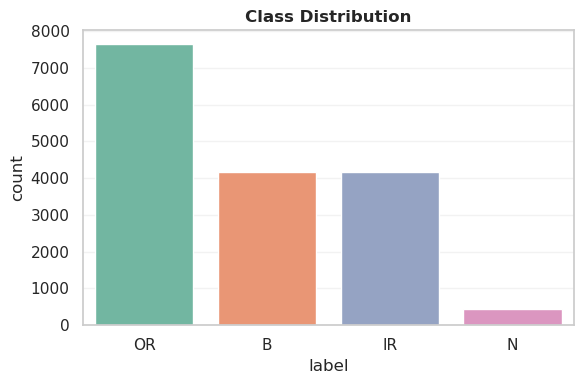

In [23]:

if label_col and df[label_col].notna().any():
    plt.figure(figsize=(6,4))
    order = df[label_col].value_counts().index
    ax = sns.countplot(x=label_col, data=df, order=order, palette=PALETTE)
    ax.set_title("Class Distribution")
    plt.tight_layout()
    plt.savefig(OUT_DIR/"class_distribution_light.png", dpi=160)
    plt.show()


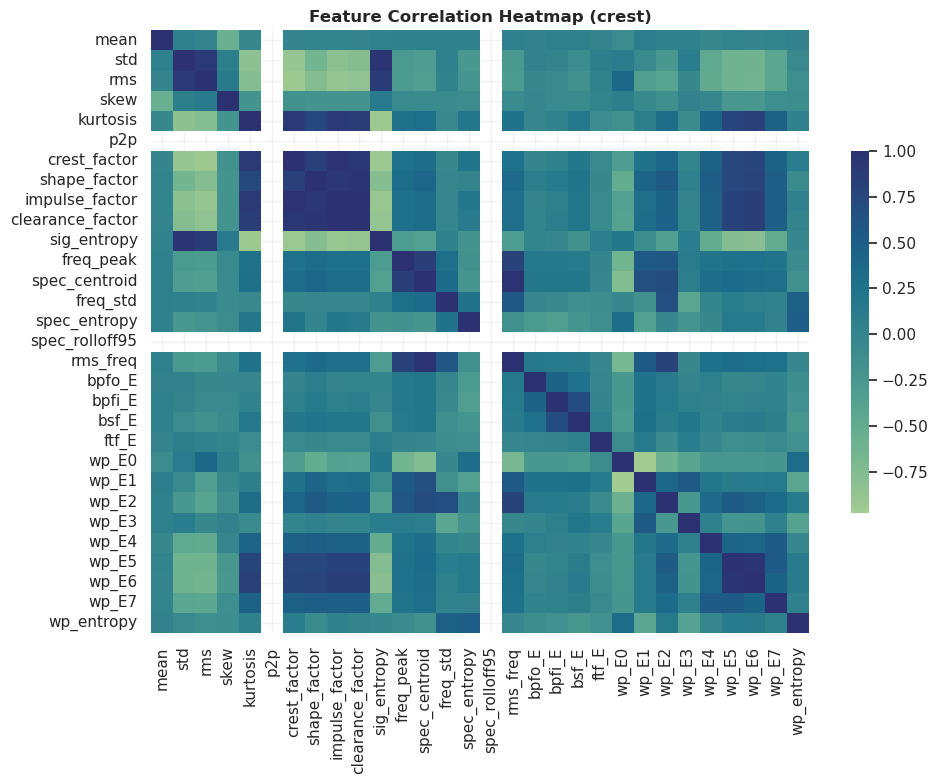

In [24]:

corr = df[feat_cols].astype(float).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="crest", center=0, cbar_kws={"shrink": .6})
plt.title("Feature Correlation Heatmap (crest)")
plt.tight_layout()
plt.savefig(OUT_DIR/"feature_correlation_crest.png", dpi=160)
plt.show()


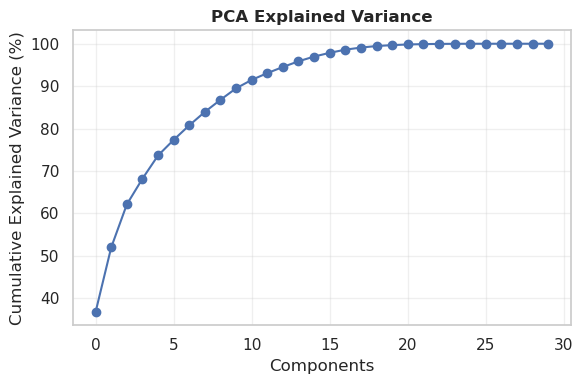

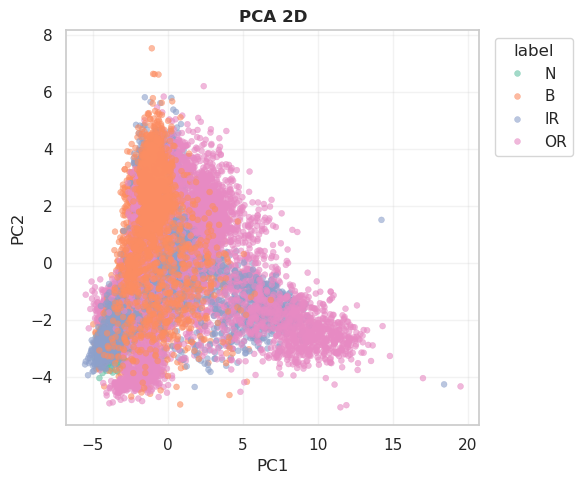

In [25]:

X = df[feat_cols].astype(float).values
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA()
Xp = pca.fit_transform(X_std)
expl_var = pca.explained_variance_ratio_

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(expl_var)*100, marker="o")
plt.xlabel("Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("PCA Explained Variance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_DIR/"pca_variance_light.png", dpi=160)
plt.show()

# 2D
plt.figure(figsize=(6,5))
if label_col and df[label_col].notna().any():
    sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=df[label_col].astype(str), palette=PALETTE, alpha=0.6, s=18, edgecolor=None)
    plt.legend(title="label", bbox_to_anchor=(1.02,1), loc="upper left")
else:
    plt.scatter(Xp[:,0], Xp[:,1], s=10, alpha=0.6)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA 2D")
plt.tight_layout()
plt.savefig(OUT_DIR/"pca_scatter_light.png", dpi=160)
plt.show()


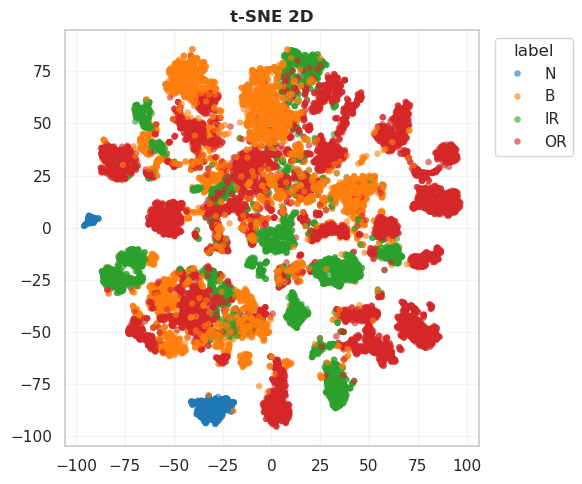

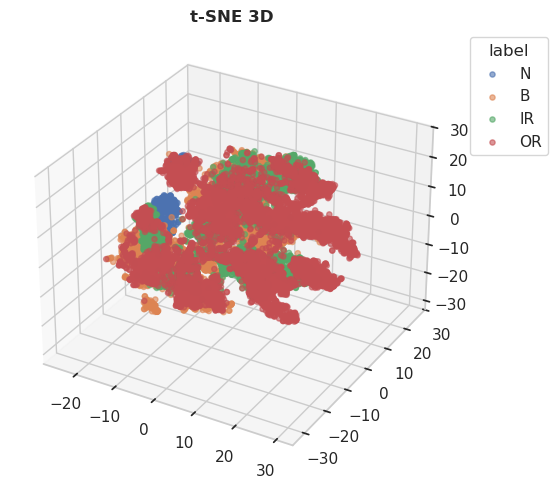

In [26]:

# t-SNE 2D
tsne2 = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto", perplexity=30)
Xt2 = tsne2.fit_transform(X_std)
plt.figure(figsize=(6,5))
if label_col and df[label_col].notna().any():
    sns.scatterplot(x=Xt2[:,0], y=Xt2[:,1], hue=df[label_col].astype(str), palette=PALETTE2, alpha=0.6, s=18, edgecolor=None)
    plt.legend(title="label", bbox_to_anchor=(1.02,1), loc="upper left")
else:
    plt.scatter(Xt2[:,0], Xt2[:,1], s=10, alpha=0.6)
plt.title("t-SNE 2D"); plt.tight_layout()
plt.savefig(OUT_DIR/"tsne2d_light.png", dpi=160)
plt.show()

# t-SNE 3D
tsne3 = TSNE(n_components=3, random_state=42, init="pca", learning_rate="auto", perplexity=35)
Xt3 = tsne3.fit_transform(X_std)
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection="3d")
if label_col and df[label_col].notna().any():
    labels = df[label_col].astype(str).values
    uniq = pd.unique(labels)
    for i, lab in enumerate(uniq):
        m = labels == lab
        ax.scatter(Xt3[m,0], Xt3[m,1], Xt3[m,2], s=14, alpha=0.6, label=str(lab))
    ax.legend(title="label", bbox_to_anchor=(1.02,1), loc="upper left")
else:
    ax.scatter(Xt3[:,0], Xt3[:,1], Xt3[:,2], s=10, alpha=0.6)
ax.set_title("t-SNE 3D")
plt.tight_layout()
plt.savefig(OUT_DIR/"tsne3d_light.png", dpi=160)
plt.show()


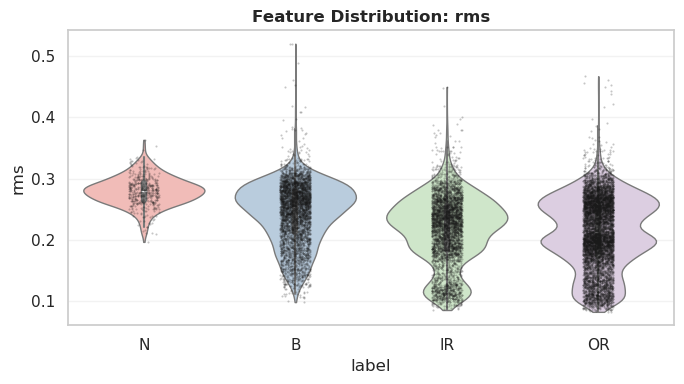

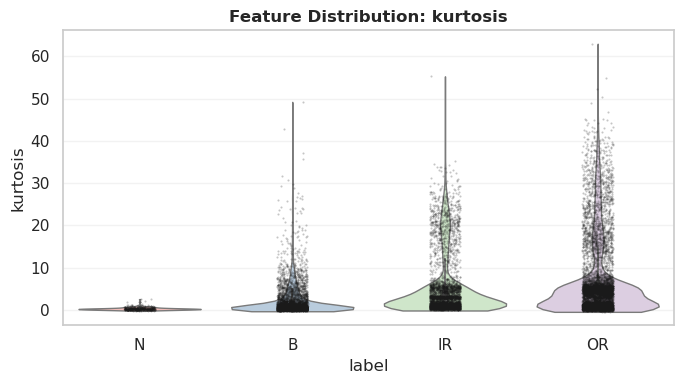

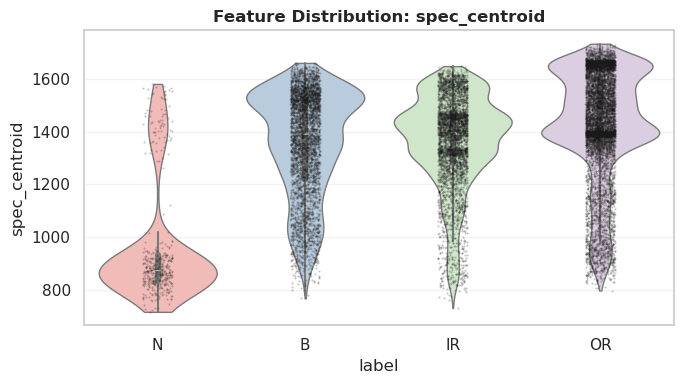

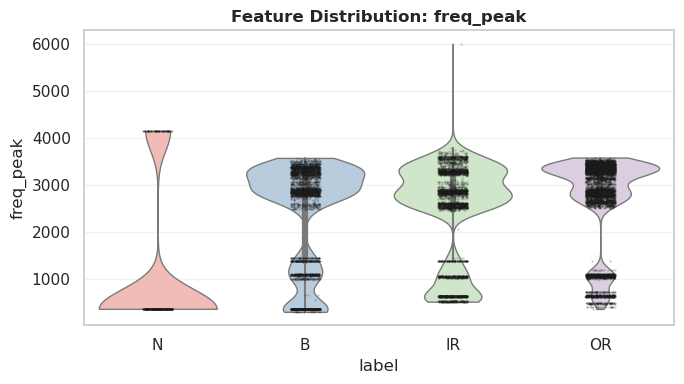

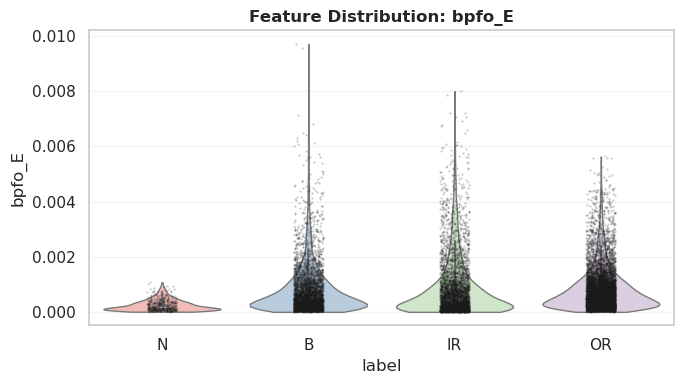

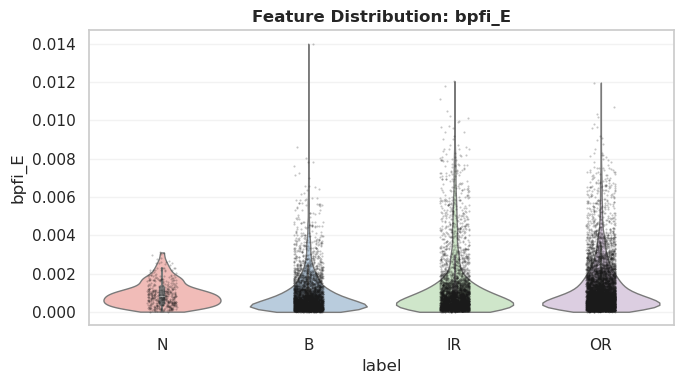

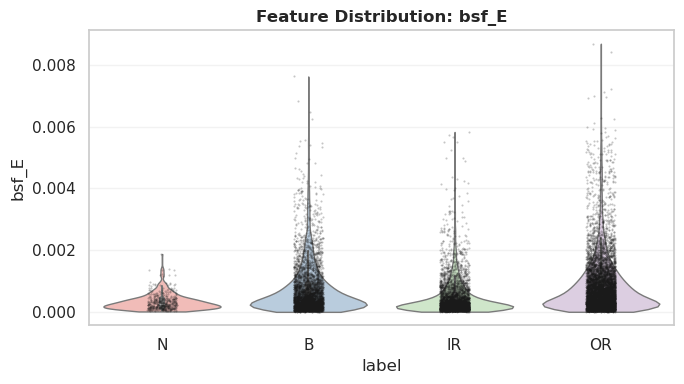

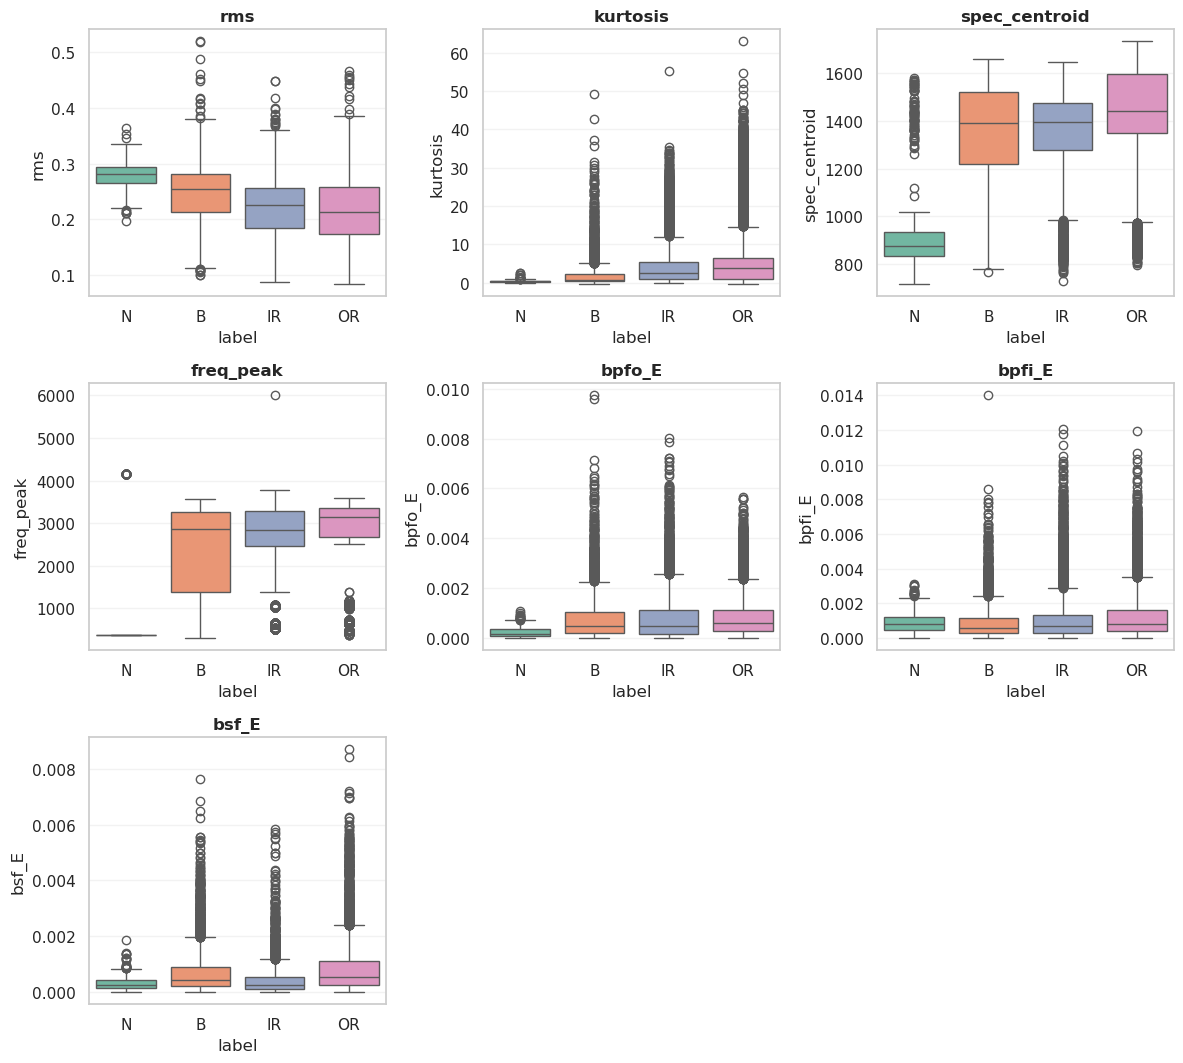

In [27]:

sel_feats = [c for c in ["rms","kurtosis","spec_centroid","freq_peak","bpfo_E","bpfi_E","bsf_E"] if c in df.columns]
if label_col and sel_feats and df[label_col].notna().any():
    for f in sel_feats:
        plt.figure(figsize=(7,4))
        ax = sns.violinplot(data=df, x=label_col, y=f, palette=PASTEL, cut=0, linewidth=1)
        sns.stripplot(data=df, x=label_col, y=f, color="k", size=1.5, alpha=0.25)
        ax.set_title(f"Feature Distribution: {f}")
        plt.tight_layout()
        plt.savefig(OUT_DIR/f"violin_{f}.png", dpi=160)
        plt.show()

    # 箱线图网格
    n = len(sel_feats)
    cols = 3
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3.6))
    axes = axes.flatten()
    for i,f in enumerate(sel_feats):
        sns.boxplot(data=df, x=label_col, y=f, palette=PALETTE, ax=axes[i])
        axes[i].set_title(f)
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.savefig(OUT_DIR/"boxgrid_selected_features.png", dpi=160)
    plt.show()


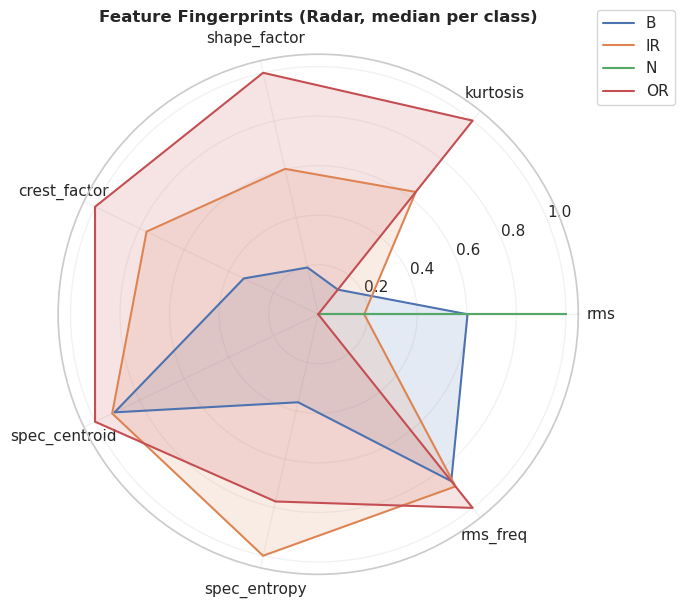

In [28]:

radar_feats = [c for c in ["rms","kurtosis","shape_factor","crest_factor","spec_centroid","spec_entropy","rms_freq"] if c in df.columns]
if label_col and radar_feats and df[label_col].notna().any():
    # 以中位数构建“指纹”
    stats = df.groupby(label_col)[radar_feats].median()
    # 0-1 归一化（按列）
    stats_norm = (stats - stats.min())/(stats.max()-stats.min()+1e-12)

    labels = list(stats_norm.columns)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    angles = np.concatenate([angles, [angles[0]]])

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, polar=True)
    for i, (cls, row) in enumerate(stats_norm.iterrows()):
        values = row.values
        values = np.concatenate([values, [values[0]]])
        ax.plot(angles, values, label=str(cls))
        ax.fill(angles, values, alpha=0.15)
    ax.set_thetagrids(angles[:-1]*180/np.pi, labels)
    ax.set_title("Feature Fingerprints (Radar, median per class)")
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.savefig(OUT_DIR/"radar_fingerprints.png", dpi=160)
    plt.show()


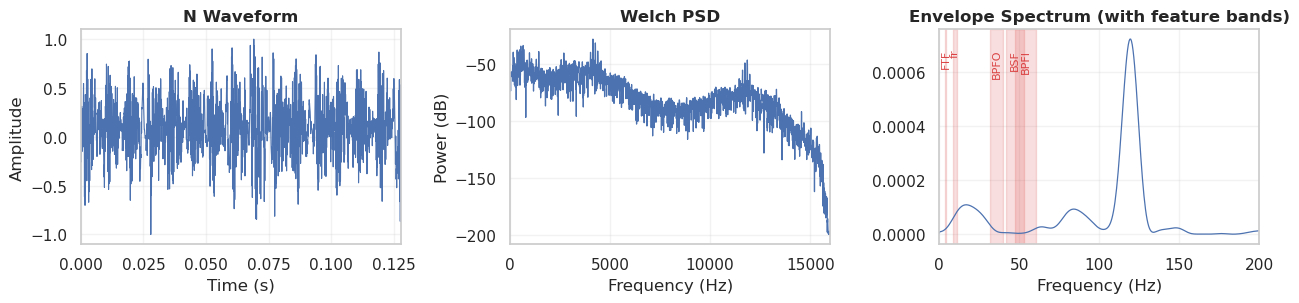

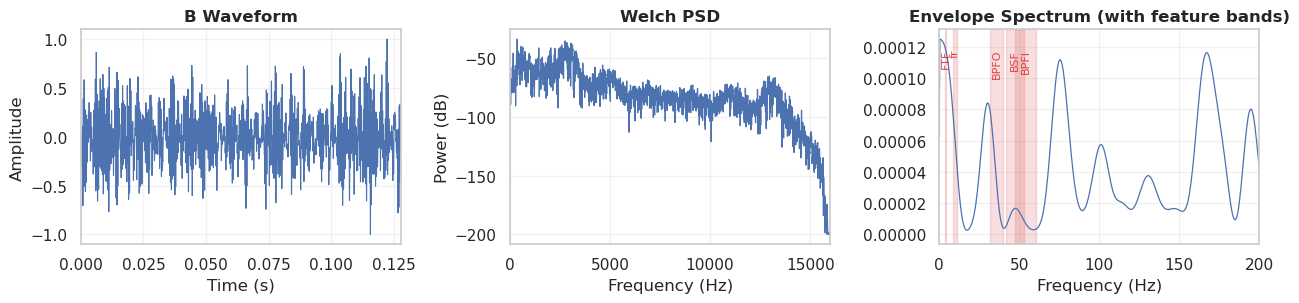

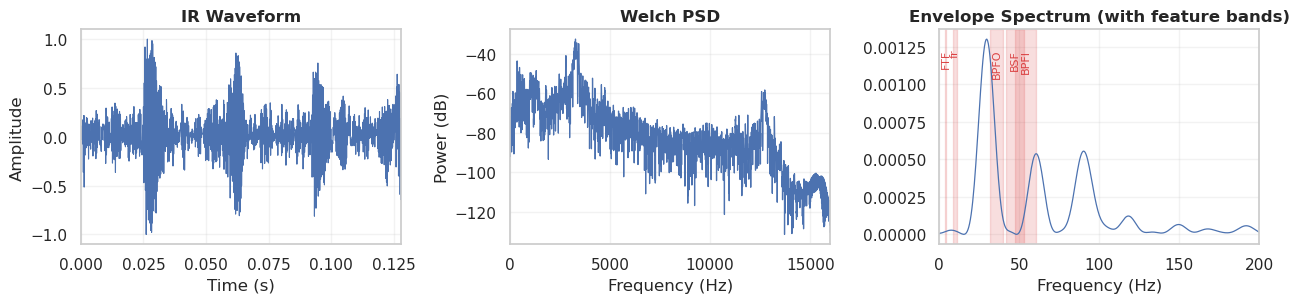

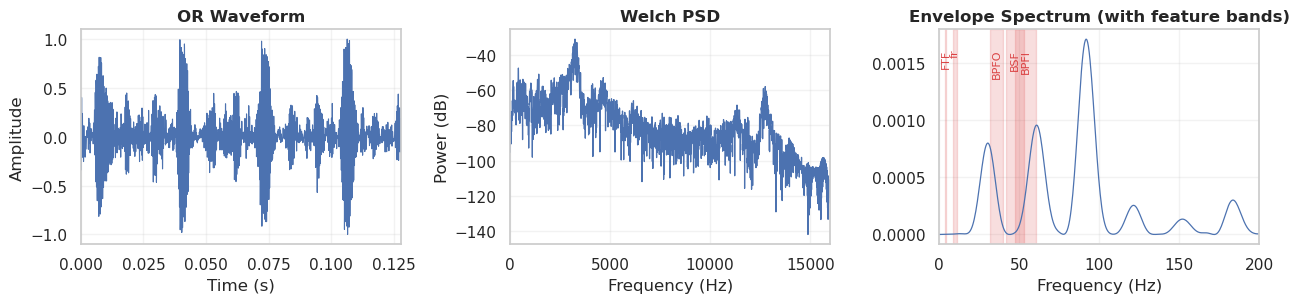

In [29]:
# —— 替换版：更好看的 波形+PSD+包络谱 ——
from scipy.signal import welch, hilbert

FS = 32000
BEARING = dict(n=9, d=0.3126, D=1.537)
RPM_DEFAULT = 600.0  # 无 rpm 时的兜底

def _char_freqs(rpm, n, d, D):
    fr   = rpm/60.0
    bpfo = fr * n/2.0 * (1 - d/D)
    bpfi = fr * n/2.0 * (1 + d/D)
    bsf  = fr * (D/d) * (1 - (d/D)**2)
    ftf  = 0.5 * fr * (1 - d/D)
    return fr, bpfo, bpfi, bsf, ftf

def _trim_const_tail(x, tol=1e-10):
    """裁掉结尾全 0/常数的“尾巴”，避免时域图后半段一条直线。"""
    x = np.asarray(x).ravel()
    if x.size == 0:
        return x
    tail = x[int(0.95*len(x)):]  # 末尾5%
    base = np.median(tail) if tail.size else 0.0
    nz = np.flatnonzero(np.abs(x - base) > tol)
    return x if nz.size == 0 else x[:nz[-1] + 1]

def pick_example_seg(label_str):
    """保持你的逻辑，同时更强壮地回退寻找 .npy 段文件。"""
    sub = df[df.get("label","").astype(str) == label_str]
    if sub.empty:
        return None
    seg_path = sub.iloc[0].get("seg_file", None)
    if pd.isna(seg_path) or seg_path is None:
        pass
    else:
        p = Path(seg_path)
        if p.exists():
            return p
        # 尝试用文件名在段目录下定位
        cand = SEG_DIR / Path(seg_path).name
        if cand.exists():
            return cand
    # 回退：在段目录里递归找一个 .npy
    if SEG_DIR.exists():
        for npy in SEG_DIR.rglob("*.npy"):
            return npy
    return None

def plot_wave_psd_env(seg_path, title_prefix="", rpm=None):
    # ----- 读取并裁尾 -----
    x = np.load(seg_path).astype(float).ravel()
    x = _trim_const_tail(x)
    t = np.arange(len(x)) / FS

    fig, axes = plt.subplots(1,3, figsize=(13,3.2))
    ax0, ax1, ax2 = axes

    # ----- 1) Waveform -----
    ax0.plot(t, x, lw=0.8)
    ax0.set_title(f"{title_prefix} Waveform")
    ax0.set_xlabel("Time (s)")
    ax0.set_ylabel("Amplitude")
    if len(t):
        ax0.set_xlim(0, t[-1])

    # ----- 2) Welch PSD（更高 nfft） -----
    nper = min(len(x), 4096) if len(x) else 1024
    nfft = max(16384, 1<<int(np.ceil(np.log2(max(1024, nper)))))
    f, Pxx = welch(x, fs=FS, nperseg=nper, noverlap=nper//2, nfft=nfft, detrend="constant")
    ax1.plot(f, 10*np.log10(Pxx + 1e-20), lw=0.9)
    ax1.set_title("Welch PSD")
    ax1.set_xlabel("Frequency (Hz)")
    ax1.set_ylabel("Power (dB)")
    ax1.set_xlim(0, FS/2)

    # ----- 3) Envelope Spectrum（自动缩放 + 频带高亮） -----
    env = np.abs(hilbert(x))
    nper_e = min(len(env), 4096) if len(env) else 1024
    nfft_e = 65536  # 分辨率 ≈ 0.49 Hz
    fe, Pe = welch(env, fs=FS, nperseg=nper_e, noverlap=nper_e//2, nfft=nfft_e, detrend="constant")
    ax2.plot(fe, Pe, lw=0.9)

    rpm_use = float(rpm) if rpm is not None and np.isfinite(rpm) and rpm > 1 else RPM_DEFAULT
    fr, bpfo, bpfi, bsf, ftf = _char_freqs(rpm_use, **BEARING)
    bands = [("fr", fr), ("BPFO", bpfo), ("BPFI", bpfi), ("BSF", bsf), ("FTF", ftf)]

    # 自动设置 x 轴上限：0 ~ max(200, 1.8×最大特征频率)，再不超过 600 Hz
    fmax_marker = max(v for _, v in bands)
    xlim_hi = min(max(200.0, 1.8*fmax_marker), 600.0)

    tol = 0.12  # 12% 的半透明频带更易读
    ymax = (Pe.max() if np.isfinite(Pe).any() else 1.0) * 0.95
    for name, v in bands:
        lo, hi = (1 - tol)*v, (1 + tol)*v
        ax2.axvspan(lo, hi, alpha=0.15, color="tab:red")
        ax2.text(v, ymax, name, rotation=90, va="top", ha="center", fontsize=8, color="tab:red", alpha=0.85)

    ax2.set_xlim(0, xlim_hi)
    ax2.set_title("Envelope Spectrum (with feature bands)")
    ax2.set_xlabel("Frequency (Hz)")

    plt.tight_layout()
    return fig


if label_col and df[label_col].notna().any():
    for lab in df[label_col].astype(str).unique():
        p = pick_example_seg(lab)
        if p is None: 
            continue
        fig = plot_wave_psd_env(p, title_prefix=str(lab))
        fig.savefig(OUT_DIR/f"wave_psd_env_{lab}.png", dpi=160)
        plt.show()
else:
    # 如果无标签，至少绘制一个样本
    if "seg_file" in df.columns and pd.notna(df.iloc[0]["seg_file"]) and Path(df.iloc[0]["seg_file"]).exists():
        fig = plot_wave_psd_env(Path(df.iloc[0]["seg_file"]), title_prefix="example")
        fig.savefig(OUT_DIR/"wave_psd_env_example.png", dpi=160)
        plt.show()


In [30]:

if TARGET_FILE_PREDS.exists():
    dft = pd.read_csv(TARGET_FILE_PREDS)
    proba_cols = [c for c in dft.columns if c.startswith("proba_")]
    if not proba_cols:
        display(dft.head())
    else:
        # Top-1 label bar
        dft_sorted = dft.copy()
        dft_sorted["pmax"] = dft[proba_cols].max(axis=1)
        dft_sorted = dft_sorted.sort_values("pmax", ascending=False)

        plt.figure(figsize=(8,6))
        ax = sns.barplot(data=dft_sorted.reset_index(), x="file", y="pmax", hue="soft_label", dodge=False, palette=PALETTE2)
        ax.set_title("Target files: Top-1 probability")
        ax.set_ylim(0,1)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(OUT_DIR/"target_file_top1.png", dpi=160)
        plt.show()

        # Stacked probabilities per file
        dfm = dft.set_index("soft_label")  # only for sorting if needed
        dft_long = dft.melt(id_vars=["soft_label"], var_name="proba_cls", value_name="prob")
        dft_long = dft_long[dft_long["proba_cls"].str.startswith("proba_")]
        dft_long["cls"] = dft_long["proba_cls"].str.replace("proba_","", regex=False)

        plt.figure(figsize=(9,6))
        # Build stacked bar manually
        files = dft["soft_label"].index if hasattr(dft["soft_label"], "index") else dft.index
        files = dft["soft_label"].tolist() if "file" not in dft.columns else dft["file"].tolist()
        files = dft["file"].tolist() if "file" in dft.columns else [f"F{i}" for i in range(len(dft))]

        classes = sorted(set(dft_long["cls"].tolist()))
        bottoms = np.zeros(len(files))
        for i, cls in enumerate(classes):
            vals = []
            for f in files:
                row = dft[dft["file"]==f].iloc[0] if "file" in dft.columns else dft.iloc[0]
                col = f"proba_{cls}"
                vals.append(float(row.get(col,0.0)))
            plt.bar(files, vals, bottom=bottoms, label=cls)
            bottoms += np.array(vals)
        plt.legend(title="class", bbox_to_anchor=(1.02,1), loc="upper left")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0,1)
        plt.title("Target files: class probability (stacked)")
        plt.tight_layout()
        plt.savefig(OUT_DIR/"target_file_stacked.png", dpi=160)
        plt.show()
else:
    print("未检测到 目标域文件级预测（第3问/outputs/target_file_preds.csv），跳过该可视化。")


,file,hard_label,proba_B,proba_IR,proba_N,proba_OR,soft_label
0,A,B,0.743094,0.002263,0.248357,0.006287,B
1,B,B,0.759932,0.001529,0.233430,0.005110,B
2,C,B,0.718937,0.001519,0.242725,0.036819,B
3,D,N,0.204278,0.000540,0.792913,0.002270,N
4,E,B,0.724569,0.000965,0.231346,0.043120,B


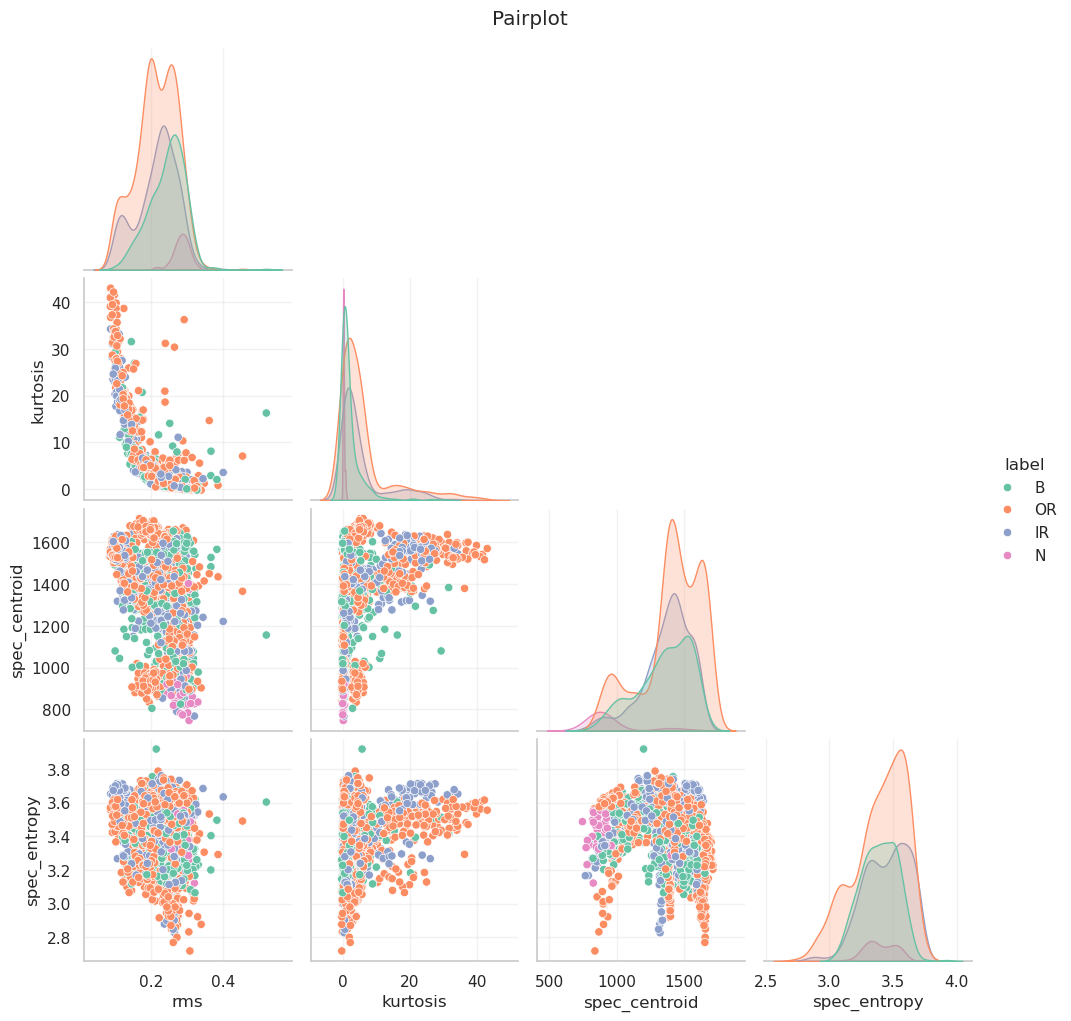

In [31]:

# 可选：小规模 pairplot（随机抽样避免过慢）
if label_col:
    base_feats = [c for c in ["rms","kurtosis","spec_centroid","spec_entropy","rms_freq"] if c in df.columns]
    if len(base_feats) >= 3:
        sample_n = min(2000, len(df))
        df_s = df[[label_col]+base_feats].sample(sample_n, random_state=42) if len(df)>sample_n else df[[label_col]+base_feats]
        g = sns.pairplot(df_s, hue=label_col, vars=base_feats[:4], corner=True, palette=PALETTE)
        g.fig.suptitle("Pairplot", y=1.02)
        g.savefig(OUT_DIR/"pairplot_light.png", dpi=160)
        plt.show()
